In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import numpy as np
import json
import matplotlib.pyplot as plt


In [2]:
dft = pd.read_csv('dataset/top12-no-outliers.csv')
dfn = pd.read_csv('dataset/noisy.csv')
dfv = pd.read_csv('dataset/vae.csv')
dfa = pd.read_csv('dataset/augmented.csv')
df = pd.concat([dft, dfa])

In [3]:
print(f"len(dft): {len(dft)} | len(dfn): {len(dfn)} | len(dfc): {len(dfv)} | len(dfa): {len(dfa)} | len(df): {len(df)}")

len(dft): 51 | len(dfn): 49 | len(dfc): 900 | len(dfa): 949 | len(df): 1000


In [4]:
Xv, yv = dfv.drop(['y'], axis=1), dfv['y']
Xt, yt = dft.drop(['y'], axis=1), dft['y']

In [5]:
def evaluate_model(y_true, y_pred, y_pred_proba, verbose=True):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    if verbose:
        print(f"Accuracy: {accuracy:.3f} | AUC: {roc_auc:.3f}")
        print(f"Sensitivity: {sensitivity:.3f} | Specificity: {specificity:.3f}")
        print(f"PPV: {ppv:.3f} | NPV: {npv:.3f}")
    return {
        'accuracy': accuracy,
        'auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'optimal_idx': optimal_idx,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
    }


# Ridge with MCMC on dataset

In [7]:
metrics = []
models = []
num_mcmc = 1000
test_size = 0.2

# Define hyperparameter grid
param_grid = {
    'alpha': np.logspace(-10, 1, num=5),
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky'],
}

for i in range(num_mcmc):
    print(f"Running MCMC {i+1}/{num_mcmc}", end='\r')
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=test_size, random_state=i)

    # Inner hyperparameter sweep
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    grid_search = GridSearchCV(RidgeClassifier(), param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Use best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.decision_function(X_test)
    
    metrics.append(evaluate_model(y_test, y_pred, y_pred_proba, verbose=False))
    models.append(best_model)

print("Done 🥸")

Done 🥸 MCMC 1000/1000


In [8]:
def json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (int, float, str, bool, type(None))):
        return obj
    elif isinstance(obj, dict):
        return {k: json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [json_serializable(item) for item in obj]
    else:
        return str(obj)

json_metrics = json.dumps(metrics, default=json_serializable)
with open('ridge_mcmc_metrics.json', 'w') as f:
    json.dump(json_metrics, f)

In [11]:
best_metric = max(metrics, key=lambda x: x['auc'])
best_model = models[metrics.index(best_metric)]
best_index = metrics.index(best_metric)
print(f"Best metric: {best_metric['auc']}")

Best metric: 0.953257932138925


In [12]:
best_metric

{'accuracy': 0.875,
 'auc': np.float64(0.953257932138925),
 'sensitivity': np.float64(0.9278350515463918),
 'specificity': np.float64(0.8640776699029127),
 'ppv': np.float64(0.8913043478260869),
 'npv': np.float64(0.8611111111111112),
 'fpr': array([0.        , 0.        , 0.        , 0.00970874, 0.00970874,
        0.01941748, 0.01941748, 0.03883495, 0.03883495, 0.04854369,
        0.04854369, 0.0776699 , 0.0776699 , 0.10679612, 0.10679612,
        0.11650485, 0.11650485, 0.13592233, 0.13592233, 0.16504854,
        0.16504854, 0.17475728, 0.17475728, 0.18446602, 0.18446602,
        0.26213592, 0.26213592, 0.32038835, 0.32038835, 0.55339806,
        0.55339806, 1.        , 1.        ]),
 'tpr': array([0.        , 0.01030928, 0.56701031, 0.56701031, 0.57731959,
        0.57731959, 0.69072165, 0.69072165, 0.78350515, 0.78350515,
        0.82474227, 0.82474227, 0.84536082, 0.84536082, 0.88659794,
        0.88659794, 0.89690722, 0.89690722, 0.92783505, 0.92783505,
        0.93814433, 0.938

In [19]:
feature_names = {
    "x1": "CXC13L",
    "x2": "EOTL",
    "x3": "GROAL",
    "x4": "HGFL",
    "x5": "IL1AL",
    "x6": "IL21L",
    "x7": "IL22L",
    "x8": "VEGFAL",
    "x9": "CD3_pos_HLA_DR_pos",
    "x10": "CD3_pos_CD4_pos_CD45RA_neg_CXCR3_pos",
    "x11": "CD3_pos_CD4_pos_CXCR5_pos_PD1_pos_ICOS_pos_CXCR3_neg",
    "x12": "CD3_neg_CD19_pos_CD21_low_CD38_low",
    "x13": "CD3_neg_CD19_pos_CD27_pos_IgD_pos_IgM_pos"
}

coeff_dict = {feature_names[f"x{i+1}"]: coeff for i, coeff in enumerate(best_model.coef_[0])}
coeff_dict

{'CXC13L': np.float64(0.1224048574475943),
 'EOTL': np.float64(0.2666371727871947),
 'GROAL': np.float64(-0.046174353003580665),
 'HGFL': np.float64(0.020928257962374887),
 'IL1AL': np.float64(-0.032073593427784174),
 'IL21L': np.float64(-0.19349064139222905),
 'IL22L': np.float64(-0.1644864201304686),
 'VEGFAL': np.float64(0.015686166903549063),
 'CD3_pos_HLA_DR_pos': np.float64(-0.1698485887657976),
 'CD3_pos_CD4_pos_CD45RA_neg_CXCR3_pos': np.float64(-0.33191257046379413),
 'CD3_pos_CD4_pos_CXCR5_pos_PD1_pos_ICOS_pos_CXCR3_neg': np.float64(0.010530829509037826),
 'CD3_neg_CD19_pos_CD21_low_CD38_low': np.float64(0.22122547288721725)}

In [20]:
auc_values = np.array([metric['auc'] for metric in metrics])

In [22]:
# Save AUC values to a text file
np.savetxt('auc_values.txt', auc_values, delimiter=',')
print("AUC values have been saved to 'auc_values.txt'")

# Display the first few AUC values
print("First few AUC values:")
print(auc_values[:5])

AUC values have been saved to 'auc_values.txt'
First few AUC values:
[0.88990091 0.9089909  0.8808928  0.8802521  0.89994987]


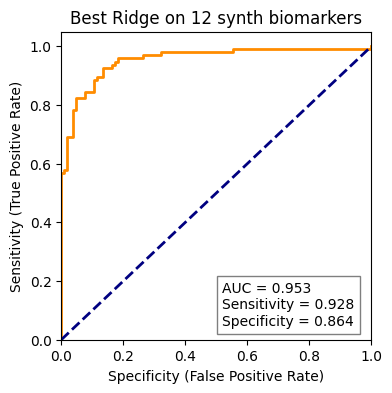

In [10]:
# Plotting
fpr = best_metric['fpr']
tpr = best_metric['tpr']
roc_auc = best_metric['auc']
sensitivity = best_metric['sensitivity']
specificity = best_metric['specificity']
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Best Ridge on 12 synth biomarkers')
#plt.legend(loc="lower right")

# Add custom text box
plt.text(0.52, 0.05, 'AUC = %0.3f\nSensitivity = %0.3f\nSpecificity = %0.3f' % (roc_auc, sensitivity, specificity),
         bbox=dict(facecolor='white', alpha=0.5))

# save fig as pdf 
plt.savefig('roc-top12-ridge-vae-mcmc-best.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()  # Close the current figure to ensure it's saved properly

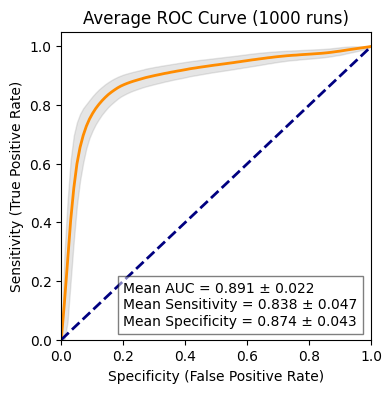

In [46]:
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def plot_average_roc(metrics, n_runs=1000):
    # Initialize variables
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    sensitivities = []
    specificities = []

    # Interpolate all ROC curves
    for metric in metrics:
        tprs.append(np.interp(mean_fpr, metric['fpr'], metric['tpr']))
        tprs[-1][0] = 0.0
        aucs.append(metric['auc'])
        sensitivities.append(metric['sensitivity'])
        specificities.append(metric['specificity'])

    # Calculate mean and std
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    # Plot the average ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Plot the standard deviation area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title(f'Average ROC Curve ({n_runs} runs)')

    # Add custom text box
    std_sensitivity = np.std(sensitivities)
    std_specificity = np.std(specificities)
    plt.text(0.20, 0.05, f'Mean AUC = {mean_auc:.3f} ± {std_auc:.3f}\nMean Sensitivity = {mean_sensitivity:.3f} ± {std_sensitivity:.3f}\nMean Specificity = {mean_specificity:.3f} ± {std_specificity:.3f}',
             bbox=dict(facecolor='white', alpha=0.5))

    # save fig as pdf
    plt.savefig('roc-top12-ridge-vae-mcmc-average.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
# Assuming 'metrics' is your list of 1000 metric dictionaries
plot_average_roc(metrics)

# XGboost with MCMC

In [6]:
metrics = []
num_mcmc = 1000
test_size = 0.2

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

for i in range(num_mcmc):
    print(f"Running MCMC {i+1}/{num_mcmc}", end='\r')
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=test_size, random_state=i)
    
    # Inner hyperparameter sweep
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    grid_search = GridSearchCV(XGBClassifier(random_state=i), param_grid, cv=kf, scoring='neg_log_loss', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Use best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    metrics.append(evaluate_model(y_test, y_pred, y_pred_proba, verbose=False))

print("Done 🥸")

Done 🥸 MCMC 1000/1000


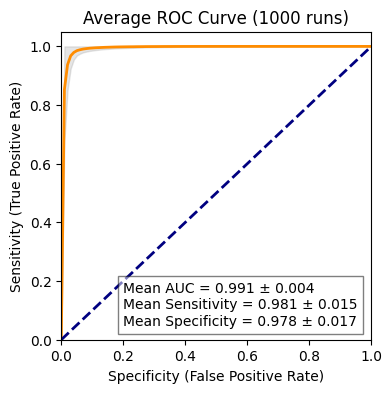

In [7]:
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def plot_average_roc(metrics, n_runs=1000):
    # Initialize variables
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    sensitivities = []
    specificities = []

    # Interpolate all ROC curves
    for metric in metrics:
        tprs.append(np.interp(mean_fpr, metric['fpr'], metric['tpr']))
        tprs[-1][0] = 0.0
        aucs.append(metric['auc'])
        sensitivities.append(metric['sensitivity'])
        specificities.append(metric['specificity'])

    # Calculate mean and std
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    # Plot the average ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Plot the standard deviation area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title(f'Average ROC Curve ({n_runs} runs)')

    # Add custom text box
    std_sensitivity = np.std(sensitivities)
    std_specificity = np.std(specificities)
    plt.text(0.20, 0.05, f'Mean AUC = {mean_auc:.3f} ± {std_auc:.3f}\nMean Sensitivity = {mean_sensitivity:.3f} ± {std_sensitivity:.3f}\nMean Specificity = {mean_specificity:.3f} ± {std_specificity:.3f}',
             bbox=dict(facecolor='white', alpha=0.5))

    # save fig as pdf
    plt.savefig('roc-top12-xgboost-vae-mcmc-average.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
# Assuming 'metrics' is your list of 1000 metric dictionaries
plot_average_roc(metrics)